In [12]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from collections import OrderedDict
import sqlite3
import pandas as pd 
import numpy as np
import numpy.linalg as LA 
import matplotlib as mpl
import matplotlib.pyplot as plt
from contextlib import closing
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse, r2_score 
from scipy import stats

In [3]:
db_name = 'macrodata.db'

sector_index = pd.read_csv('sector_index.csv')
sectoral_tfp = pd.read_csv('sectoral_tfp.csv')
tfp_growth = pd.read_csv('aggregate_tfp_growth.csv')
gabaix_vol = pd.read_csv('fundamental_vol.csv')
domar_weights = pd.read_csv('domar_weights.csv').set_index(['year'])
sector_varcov = np.loadtxt('sector_varcov.csv')
rebased_prices = pd.read_csv('rebased_prices_io.csv').fillna(1.).values[2:,1:]
real_io = pd.read_csv('real_io.csv').fillna(0)
nominal_io = pd.read_csv('nominal_io.csv')
rebased_io = pd.read_csv('rebased_io.csv')
del nominal_io['Unnamed: 0']
del nominal_io['sector']
del nominal_io['99']
del real_io['Unnamed: 0']
del real_io['sector']
del real_io['99']
del sector_index['Unnamed: 0']
del gabaix_vol['outer']

sectoral_tfp = sectoral_tfp.set_index(['year']).sort_index(level=0)
nominal_io = nominal_io.set_index(['year', 'sector_id']).sort_index(level=0)
real_io = real_io.set_index(['year', 'sector_id']).sort_index(level=0)
gabaix_vol = pd.Series(gabaix_vol.set_index(['year'])['inner'])

with closing(sqlite3.connect(db_name)) as engine:
    aggregate_output=pd.read_sql('SELECT * FROM output_aggregate', engine).set_index(['year'])

In [4]:
def svd_plot(data, year, index=sector_index, top_n=2, orientation='Input', size=(20,18)):
    L = data.loc[year].values 
    U, S, Vh = np.linalg.svd(L, full_matrices=True); Uh = -U.transpose(); Vh = -Vh; 
    data = ({'sector': index['sector']}); data.update({'%s component %s' % (orientation, i+1): Vh[i] if orientation == 'Input' else Uh[i] for i in range(top_n)})
    pd.DataFrame(data).set_index('sector').sort_values(by=['%s component 1' %(orientation)], ascending=False).plot(use_index=True, kind='bar', subplots=True, sharex=False, figsize=(40, 18), layout=(1,top_n), fontsize=12)
    
def svd_fit(data, year, top_n, index=sector_index):
    L = data.loc[year].values 
    U, S, Vh = np.linalg.svd(L, full_matrices=True); U = -U; Vh = - Vh;
    

In [5]:
def chained_outputs(nominal_inputs, tornqvist_prices):
    inputs = nominal_inputs.copy()[nominal_inputs.columns[3:]]
    years = {str(list(nominal_io.index.levels[0])[i]): i for i in range(len(tornqvist_prices))}
    return inputs.groupby('year').apply(lambda x: x.apply(lambda y: y/tornqvist_prices[years[str(x.name)]], axis=1))


def total_requirements_from_direct_requirements(requirements):
    requirements = requirements.copy().drop(['output', 'capital', 'labor'], errors='ignore', axis=1)
    return requirements.groupby(level=0).apply(lambda x: pd.DataFrame(LA.inv(np.identity(len(x)) - x.values), index = sector_index['sector_id'], columns=list(sector_index['sector_id'])))

chained_io = chained_outputs(nominal_io, rebased_prices)
input_shares = 1 - (nominal_io.capital + nominal_io.labor)/nominal_io.output
chained_io['output'] = chained_io.sum(axis=1) / input_shares
direct_requirements_matrix = chained_io.copy().fillna(1); direct_requirements_matrix = direct_requirements_matrix[direct_requirements_matrix.columns[:-1]].apply(lambda x: x/direct_requirements_matrix[direct_requirements_matrix.columns[-1]], axis=0)
total_requirements_matrix = total_requirements_from_direct_requirements(direct_requirements_matrix)

In [6]:
def influence_vector(data, input_shares):
    data = data.copy()
    data['input_share'] = pd.DataFrame(input_shares, columns=['input_share'])['input_share']
    return data.groupby(level=0).apply(lambda x: pd.DataFrame(x[x.columns[:-1]].values.dot(np.ones(len(x)))/len(x), index=sector_index['sector_id'], columns=['influence'])).unstack()

def svd_reduced_requirements(requirements):
    U_t, S_t, Vh_t = LA.svd(np.array(np.split(requirements.values, 46, axis=0)), full_matrices=True)
    years = list(requirements.index.levels[0])
    reduced_requirements = lambda n: {years[i]: (U_t[i][:,:n] * S_t[i][:n]) @ Vh_t[i][:n,:] for i in range(len(years))}
    return [requirements.groupby('year').apply(lambda x: pd.DataFrame(reduced_requirements(k)[x.name], index=sector_index['sector_id'], columns=requirements.columns)) for k in range(1, 77+1)]

In [7]:
reduced_requirements = svd_reduced_requirements(total_requirements_matrix)

In [8]:
def fundamental_volatility(influence_vector, varcov):
    sig = varcov.diagonal()
    return influence_vector.groupby('year').apply(lambda x: np.sum((x.values**2)*sig))

def projected_fundamental_volatility(reduced_requirements, varcov, baseline=gabaix_vol):
    out = OrderedDict({'baseline': stats.zscore(baseline)})
    out.update({'{}_components'.format(k+1): stats.zscore(fundamental_volatility(influence_vector(reduced_requirements[k], input_shares), varcov)) for k in range(len(reduced_requirements))})
    return pd.DataFrame(out, index=list(total_requirements_matrix.index.levels[0]))

In [9]:
projected_volatilities = projected_fundamental_volatility(reduced_requirements, sector_varcov)

In [10]:
def score_by_components(vols, baseline):
    return pd.DataFrame([np.correlate(vols[vols.columns[baseline]].values, vols[vols.columns[k]].values)/46 for k in range(1, len(vols.columns))], index=range(1, len(vols.columns)))

In [11]:
correlations = pd.DataFrame({'sales_vector':score_by_components(projected_volatilities, 0).values.flatten(), 'influence_vector':score_by_components(projected_volatilities, -1).values.flatten()})

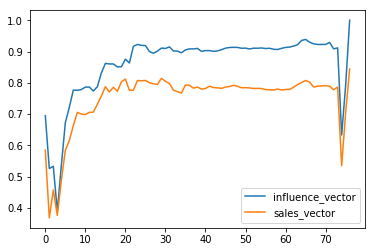

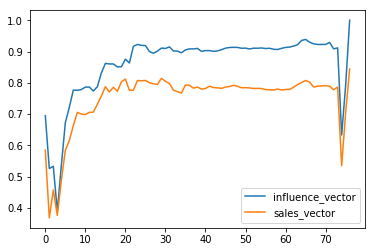

In [14]:
correlations.plot()
plt.show()

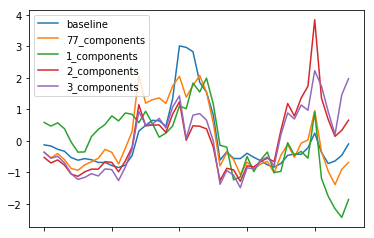

In [19]:
projected_volatilities[projected_volatilities.columns[[0, -1, 1, 2, 3]]].plot()
plt.show()

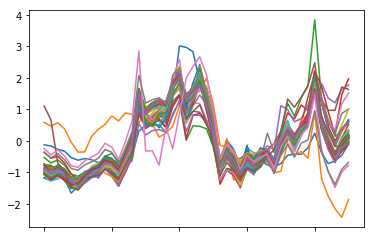

In [20]:
projected_volatilities.plot(legend=False)
plt.show()

In [30]:
log_sector_output_cycle = pd.read_csv('log_sector_output_cycle.csv').set_index('year')

In [160]:
def calculate_sectoral_shocks(reduced_requirements, y):
    out = [] 
    for requirements in reduced_requirements:
        df = requirements.groupby('year').apply(lambda x: pd.Series(LA.pinv(x).dot(y.loc[x.name].values)))
        df.columns = y.columns
        out.append(df)
    return out

def corr2(A, B):
    A_ = A - A.mean(1)[:,None]
    B_ = B - B.mean(1)[:,None]
    A_ssq = (A_**2).sum(1)
    B_ssq = (B_**2).sum(1)
    return np.dot(A_, B_.T)/np.sqrt(np.dot(A_ssq[:,None], B_ssq[None]))

def mse(A, B, ax=1):
    return ((A-B)**2).mean(axis=ax)

In [155]:
sectoral_shocks = calculate_sectoral_shocks(reduced_requirements, log_sector_output_cycle)

In [174]:
def score(shocks):
    baseline = shocks[-1]
    out = pd.DataFrame()
    for i in range(0, len(shocks) - 1):
        out[i] = pd.Series(corr2(shocks[i].values, baseline.values).diagonal())
    return out

In [175]:
scores = score(sectoral_shocks)

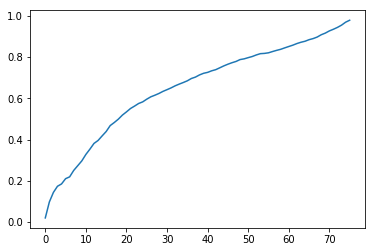

In [179]:
scores.mean(0).plot()
plt.show()